In [88]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# model_name = "EmbeddingAndCNNModel"
model_name = "EmbeddingAnd2dCNNModel"
# target_feature = "endianness"
target_feature = "instructionwidth_type"

In [89]:
# Specify the directory containing the CSV files
directory = "../../results/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "*.csv"))
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Filter on model and target feature
df = df[
    (df["model.name"] == model_name) & (df["target_feature"] == target_feature)
].reset_index(drop=True)

In [90]:
# Compute mean and std of overall accuracy
df_overall = df[df["Name"] == "overall_metrics"][["overall_accuracy"]]
overall_mean = df_overall["overall_accuracy"].mean()
overall_std = df_overall["overall_accuracy"].std()

# Remove unnecessary columns
df_filtered = df[["Name", "test_accuracy", "test_loss", "train_loss"]]

# Remove aggregation rows and rename columns
df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
    columns={"Name": "architecture"}
)

df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

df_folds.head()

,architecture,test_accuracy,test_loss,train_loss
1,x32,0.999521,1.555660e-03,0.006385
2,sparc64,0.981990,6.308602e-02,0.007436
3,sparc,1.000000,2.293972e-07,0.007026
4,sh4,0.993255,1.735183e-01,0.118470
5,s390x,0.997739,1.351828e-02,0.014972


In [91]:
df_agg = (
    df_folds.groupby("architecture")
    .agg({"test_accuracy": ["mean", "std"]})
    .sort_values(("test_accuracy", "mean"), ascending=False)
    .reset_index()
)

df_agg

architecture test_accuracy          
                         mean       std
0         sparc      1.000000  0.000000
1    powerpcspe      1.000000  0.000000
2       powerpc      1.000000  0.000000
3       riscv64      0.999977  0.000071
4           sh4      0.999309  0.002128
5           x32      0.999210  0.001035
6      mips64el      0.999072  0.001573
7        mipsel      0.998967  0.001501
8         amd64      0.997801  0.003522
9          i386      0.992817  0.010670
10        armhf      0.989812  0.005096
11      sparc64      0.989164  0.006760
12        armel      0.988375  0.020040
13         mips      0.970098  0.050360
14        arm64      0.936991  0.105202
15         ia64      0.921770  0.190056
16         s390      0.889078  0.225320
17      ppc64el      0.796367  0.305814
18         hppa      0.786894  0.265903
19        s390x      0.772499  0.329757
20         m68k      0.534568  0.456902
21        ppc64      0.491987  0.311845
22        alpha      0.304281  0.105531

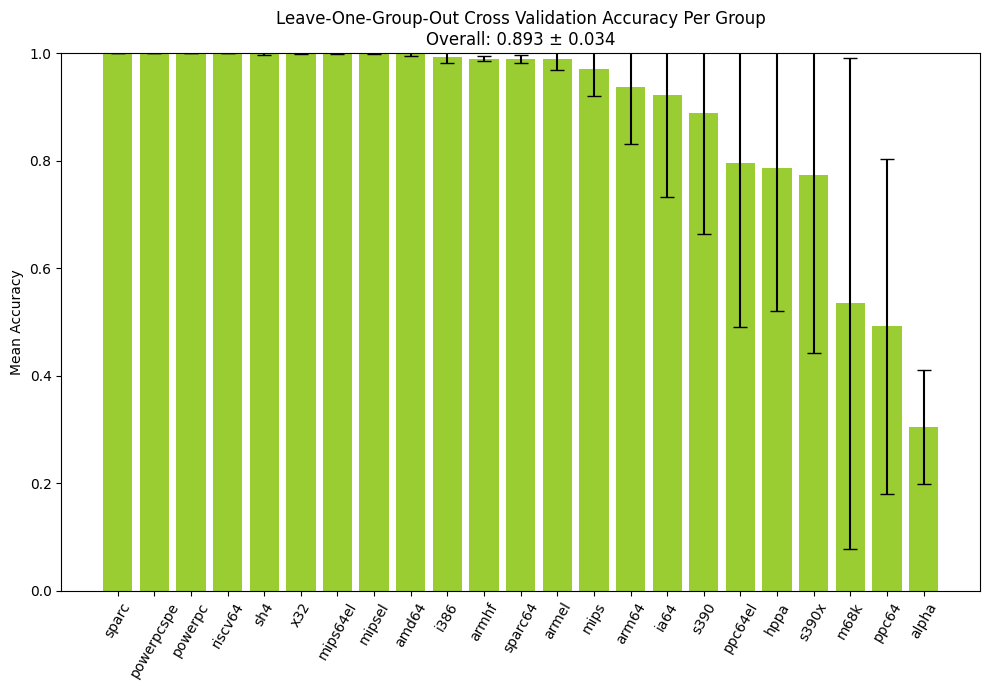

In [92]:
means = df_agg[("test_accuracy", "mean")].values
stds = df_agg[("test_accuracy", "std")].values
architectures = df_agg["architecture"].values

plt.figure(figsize=(10, 7))
bars = plt.bar(
    range(len(architectures)), means, yerr=stds, capsize=5, color="yellowgreen"
)

plt.xticks(range(len(architectures)), architectures, rotation=60)
plt.title(
    f"Leave-One-Group-Out Cross Validation Accuracy Per Group\nOverall: {overall_mean:.3f} ± {overall_std:.3f}"
)
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)

plt.tight_layout()